In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

file_path = '/content/drive/MyDrive/NLP_assignment_4/'
# file_path = '/kaggle/input/task2-data/'

In [4]:
!pip install torch transformers


In [6]:
import json
from transformers import AutoTokenizer
import torch
import os

# model_name = 'DeepPavlov/bert-base-cased-conversational'
model_name = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
emo_to_idx = {"fear": 0, "disgust": 1, "anger": 2, "sadness": 3, "joy": 4, "surprise": 5, "neutral": 6}
idx_to_emo = {0: "fear", 1: "disgust", 2: "anger", 3: "sadness", 4: "joy", 5: "surprise", 6: "neutral"}

def preprocess_data(data, tokenizer):
    processed_data = []
    for episode_data in data:
        utterances = episode_data['utterances']
        emotions = episode_data['emotions']
        speakers = episode_data['speakers']
        triggers = [0 if trg is None else trg for trg in episode_data['triggers']]

        if not utterances or not emotions or not triggers or not speakers:
            continue

        tokens = tokenizer(utterances, padding=True, truncation=True, return_tensors='pt')

        emotion_labels = [emo_to_idx[emotion] for emotion in emotions]

        speaker_ids = tokenizer(speakers, padding=True, truncation=True, return_tensors='pt')

        processed_data.append({
            'input_ids': tokens['input_ids'],
            'attention_mask': tokens['attention_mask'],
            'emotion_labels': torch.tensor(emotion_labels, dtype=torch.long),  # Convert to tensor
            'triggers': torch.tensor(triggers, dtype=torch.float),
            'speaker_ids': speaker_ids['input_ids']
        })

    return processed_data

# train_data_path = file_path +'train_file.json'
# val_data_path = file_path + 'val_file.json'

# with open(train_data_path, 'r') as file:
#     train_data = json.load(file)

# preprocessed_train_data = preprocess_data(train_data, tokenizer)

# with open(val_data_path, 'r') as file:
#     val_data = json.load(file)
# preprocessed_val_data = preprocess_data(val_data, tokenizer)

# print(preprocessed_train_data[0])

# torch.save({
#     'train': preprocessed_train_data,
#     'val': preprocessed_val_data
# }, file_path + 'preprocessed_data.pth')

#demo
test_data_path = '/content/drive/MyDrive/NLP_assignment_4/MELD_train_efr.json'

with open(test_data_path, 'r') as file:
    test_data = json.load(file)
preprocessed_test_data = preprocess_data(test_data, tokenizer)


In [7]:
import torch
import os

loaded_data = torch.load(file_path + 'preprocessed_data.pth')

loaded_train_data = loaded_data['train']
loaded_val_data = loaded_data['val']

In [8]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, preprocessed_data):
        self.preprocessed_data = preprocessed_data

    def __len__(self):
        return len(self.preprocessed_data)

    def __getitem__(self, idx):
        item = self.preprocessed_data[idx]
        return {
            'input_ids': item['input_ids'],
            'attention_mask': item['attention_mask'],
            'emotion_labels': item['emotion_labels'],
            'triggers': item['triggers'],
            'speaker_ids': item['speaker_ids']
        }

train_dataset = CustomDataset(loaded_train_data)
val_dataset = CustomDataset(loaded_val_data)


#demo
test_dataset = CustomDataset(preprocessed_test_data)

In [10]:
from torch.nn.utils.rnn import pad_sequence
from torch.nn.functional import pad

def custom_collate_fn(batch):

    max_length = max(item['input_ids'].shape[1] for item in batch)
    max_length_emotion_labels = max(item['emotion_labels'].shape[0] for item in batch)

    input_ids_padded = pad_sequence([pad(item['input_ids'], (0, max_length - item['input_ids'].shape[1]), 'constant', 0) for item in batch], batch_first=True)
    attention_mask_padded = pad_sequence([pad(item['attention_mask'], (0, max_length - item['attention_mask'].shape[1]), 'constant', 0) for item in batch], batch_first=True)
    max_speaker_id_length = max(item['speaker_ids'].shape[1] for item in batch)

    #Padding speaker_ids so they all have the same second dimension
    speaker_ids_padded = pad_sequence([pad(item['speaker_ids'], (0, max_speaker_id_length - item['speaker_ids'].shape[1])) for item in batch], batch_first=True)

    #Padding emotion_labels with a different padding value (-1)
    emotion_labels_padded = pad_sequence([pad(item['emotion_labels'], (0, max_length_emotion_labels - item['emotion_labels'].shape[0]), 'constant', -1) for item in batch], batch_first=True)

    triggers_padded = pad_sequence([item['triggers'] for item in batch], batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'emotion_labels': emotion_labels_padded,
        'triggers': triggers_padded,
        'speaker_ids': speaker_ids_padded
    }

sample_data = [train_dataset[i] for i in range(2)]
collated_sample = custom_collate_fn(sample_data)
t = 40
num_labels = 7
print(collated_sample)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)


# demo
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=custom_collate_fn)

{'input_ids': tensor([[[  101,  1192,   118,  1128,  7490,  1358,  1125,  2673,  1114, 23500,
            136,   106,   102,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0],
         [  101, 11205,   117,   170,  1376,  2113,   119,  1153,   118,  1131,
            118,  1131,  2045,  1107,  1105,   146,  1354,  1131,  1108,  1128,
           1105,   146,  4005,  1123,  1105,   102,     0,     0,     0,     0,
              0,     0,     0],
         [  101,  1192,  1238,   112,   189,  4430,  1131,  1108,  3351,  1472,
           3459,   136,   106,   102,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0],
         [  101,  2119,   146,  1108,  1198,  1177,  7215,  1106,  1267,  1128,
            119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
          

In [12]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
device = 'cpu'

class BertForEmotionClassificationWithSpeakerIDs(nn.Module):
    def __init__(self, num_labels, speaker_id_embedding_size=20):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(0.1)
        self.speaker_embeddings = nn.Embedding(num_embeddings=102, embedding_dim=speaker_id_embedding_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size + speaker_id_embedding_size, 1)

    def forward(self, input_ids=None, attention_mask=None, speaker_ids=None, labels=None):

        outputs = self.bert(input_ids, attention_mask=attention_mask, return_dict=True)
        sequence_output = outputs.last_hidden_state
        # print("Sequence output shape:", sequence_output.shape)

        speaker_embeddings = self.speaker_embeddings(speaker_ids)
        speaker_embeddings = speaker_embeddings.unsqueeze(1).expand(-1, sequence_output.size(1), -1)

        sequence_output = torch.cat((sequence_output, speaker_embeddings), dim=2)
        # print("Concatenated output shape:", sequence_output.shape)

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        logits = logits.squeeze(-1)
        # print("Logits shape:", logits.shape)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            logits = logits.view(-1, logits.shape[-1])
            labels = labels.long()
            loss = loss_fct(logits, labels)

        return SequenceClassifierOutput(loss=loss, logits=logits)

In [ ]:
import os
import torch

num_epochs = 3

checkpoint_files = [f for f in os.listdir(file_path) if f.startswith('model_checkpoint') and f.endswith('.pth')]
if checkpoint_files:
    latest_checkpoint_file = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    checkpoint_path = os.path.join(file_path, latest_checkpoint_file)

    checkpoint = torch.load(checkpoint_path)

    model = BertForEmotionClassificationWithSpeakerIDs(num_labels).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint['epoch'] + 1

    print(f"Checkpoint loaded from {checkpoint_path}, starting training at epoch {start_epoch}")
else:
    model = BertForEmotionClassificationWithSpeakerIDs(num_labels).to(device)
    optimizer = AdamW(model.parameters(), lr=1e-5)
    num_epochs = 1
    train_losses = []

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*num_epochs)
    start_epoch = 0

    print("No checkpoint found, starting training from scratch")

Checkpoint loaded from /kaggle/input/models1/model_checkpoint_epoch_1.pth, starting training at epoch 1


In [ ]:
num_epochs = 3
file_path_o = '/kaggle/working/'

# model = BertForEmotionClassificationWithSpeakerIDs(num_labels).to(device)
# optimizer = AdamW(model.parameters(), lr=1e-5)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*num_epochs)
train_losses = []
model.train()
for epoch in range(start_epoch, num_epochs + 1):
    total_loss = 0
    i = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].view(-1, batch['input_ids'].size(-1))
        attention_mask = batch['attention_mask'].view(-1, batch['attention_mask'].size(-1))
        speaker_ids = batch['speaker_ids'][:, :, 0].view(-1)  # Shape: (batch_size * num_dialogues)
        labels = batch['triggers'].view(-1)  # Shape: (batch_size * num_dialogues)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        speaker_ids = speaker_ids.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, speaker_ids=speaker_ids, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        optimizer.zero_grad()
        i += 1
        print(f"Batch loss {i}: {loss.item()}")
        total_loss += loss.item()

    avg_batch_loss = total_loss / len(train_loader)
    train_losses.append(avg_batch_loss)

    checkpoint_path = file_path_o + f'model_checkpoint_epoch_{epoch+1}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_batch_loss,
    }, checkpoint_path)

    print(f"Epoch {i + 1}, Average training loss: {avg_batch_loss}")

Epoch 1, Average training loss: 6.265022221391237
Epoch 2, Average training loss: 5.548839330673218
Epoch 3, Average training loss: 5.315602254867554


In [ ]:
# num_epochs = 1

#
# model = BertForEmotionClassificationWithSpeakerIDs(num_labels).to(device)
# optimizer = AdamW(model.parameters(), lr=1e-5)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*num_epochs)

# model.train()
# train_losses = []
# for epoch in range(num_epochs):
#     total_loss = 0
#     for batch in train_loader:
#         input_ids = batch['input_ids'].view(-1, batch['input_ids'].size(-1))
#         attention_mask = batch['attention_mask'].view(-1, batch['attention_mask'].size(-1))
#         speaker_ids = batch['speaker_ids'][:, :, 0].view(-1)  # Shape: (batch_size * num_dialogues)
#         labels = batch['triggers'].view(-1)  # Shape: (batch_size * num_dialogues)

#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)
#         speaker_ids = speaker_ids.to(device)
#         labels = labels.to(device)

#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, speaker_ids=speaker_ids, labels=labels)
#         loss = outputs.loss
#         logits = outputs.logits

#         # Backward pass
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         optimizer.zero_grad()

#         total_loss += loss.item()

#     avg_batch_loss = total_loss / len(train_loader)
#     train_losses.append(avg_batch_loss)

#     checkpoint_path = file_path + f'model_checkpoint_epoch_{epoch+1}.pth'
#     torch.save({
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': avg_batch_loss,
#     }, checkpoint_path)

#     print(f"Checkpoint saved for epoch {epoch+1} at {checkpoint_path}")
#     print(f"Epoch {epoch + 1}, Average training loss: {avg_batch_loss}")

Logits shape: torch.Size([480, 61])

Labels shape: torch.Size([480])

Current batch loss: 3.882808208465576

Logits shape: torch.Size([768, 53])

Labels shape: torch.Size([768])

Current batch loss: 3.6156022548675537

Logits shape: torch.Size([640, 38])

Labels shape: torch.Size([640])

Current batch loss: 3.140103816986084

Logits shape: torch.Size([608, 40])

Labels shape: torch.Size([608])

Current batch loss: 3.0429956912994385

Logits shape: torch.Size([768, 43])

Labels shape: torch.Size([768])

Current batch loss: 2.938504934310913

Logits shape: torch.Size([576, 45])

Labels shape: torch.Size([576])

Current batch loss: 2.8124637603759766

Logits shape: torch.Size([608, 95])

Labels shape: torch.Size([608])

Current batch loss: 3.273076295852661

Logits shape: torch.Size([608, 48])

Labels shape: torch.Size([608])

Current batch loss: 2.563206434249878

Logits shape: torch.Size([512, 43])

Labels shape: torch.Size([512])

Current batch loss: 2.2631194591522217

Logits shape: t

In [ ]:
model_save_path = file_path + "model_checkpoint_epoch_3.pt"

model = BertForEmotionClassificationWithSpeakerIDs(num_labels).to(device)

torch.save(model.state_dict(), model_save_path)

print(f"Model saved to '{model_save_path}'")


config.json: 100%|██████████| 570/570 [00:00<00:00, 57.0kB/s]
model.safetensors: 100%|██████████| 436M/436M [00:25<00:00, 17.2MB/s] 


Model saved to 'bert_emotion_classification_model_epoch_0.pt'


In [ ]:
from sklearn.metrics import f1_score, accuracy_score
import torch
import torch.nn.functional as F

def pad_tensors_to_max_len(tensors, max_len):
    padded_tensors = []
    for tensor in tensors:
        if tensor.dim() == 1:
            if tensor.size(0) < max_len:
                padded = F.pad(tensor, pad=(0, max_len - tensor.size(0)))
            else:
                padded = tensor
        else:
            if tensor.size(1) < max_len:
                padded = F.pad(tensor, pad=(0, max_len - tensor.size(1)))
            else:
                padded = tensor
        padded_tensors.append(padded)
    return padded_tensors

val_logits = []
val_labels = []
val_losses = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].view(-1, batch['input_ids'].size(-1))
        attention_mask = batch['attention_mask'].view(-1, batch['attention_mask'].size(-1))
        speaker_ids = batch['speaker_ids'][:, :, 0].view(-1)
        labels = batch['triggers'].view(-1)

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        speaker_ids = speaker_ids.to(device)
        labels = labels.to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, speaker_ids=speaker_ids, labels=labels)
        val_loss = outputs.loss
        val_losses.append(val_loss.item())
        logits = outputs.logits
        val_logits.append(logits.detach().cpu())
        val_labels.append(labels.detach().cpu())

max_len = max(tensor.size(1) for tensor in val_logits)

val_logits_padded = pad_tensors_to_max_len(val_logits, max_len)
val_labels_padded = pad_tensors_to_max_len(val_labels, max_len)

val_logit = torch.cat(val_logits_padded, dim=0)
val_labels = torch.cat(val_labels_padded, dim=0)
val_logits = torch.where(val_logit > t, torch.tensor(1.0), torch.tensor(0.0))

val_preds = torch.argmax(val_logits, dim=-1)
f1 = f1_score(val_labels.numpy(), val_preds.numpy(), average='macro')
accuracy = accuracy_score(val_labels.numpy(), val_preds.numpy())

print(f"Validation Loss: {sum(val_losses) / len(val_losses)}")
print(f"F1 Score: {f1}")

Validation Loss: 3.5175913439856634
F1 Score: 0.4825366777094179


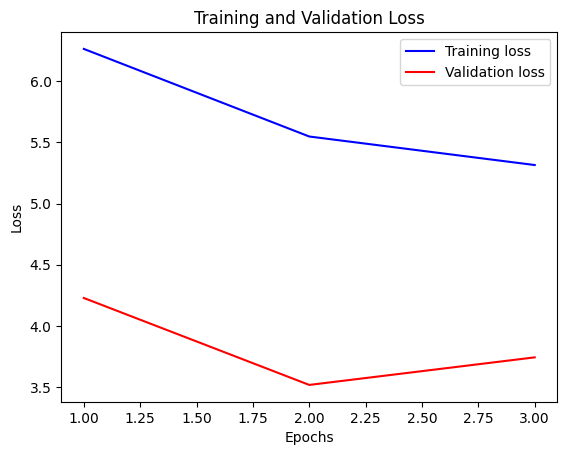

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)

# Demo

In [13]:
model_save_path = file_path + "/model_checkpoint_epoch_3.pt"

model = BertForEmotionClassificationWithSpeakerIDs(num_labels).to(device)

torch.save(model.state_dict(), model_save_path)

print(f"Model saved to '{model_save_path}'")


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Model saved to '/content/drive/MyDrive/NLP_assignment_4//model_checkpoint_epoch_3.pt'


In [23]:
from sklearn.metrics import f1_score, accuracy_score
import torch
import torch.nn.functional as F

def pad_tensors_to_max_len(tensors, max_len):
    padded_tensors = []
    for tensor in tensors:
        if tensor.dim() == 1:
            if tensor.size(0) < max_len:
                padded = F.pad(tensor, pad=(0, max_len - tensor.size(0)))
            else:
                padded = tensor
        else:
            if tensor.size(1) < max_len:
                padded = F.pad(tensor, pad=(0, max_len - tensor.size(1)))
            else:
                padded = tensor
        padded_tensors.append(padded)
    return padded_tensors

test_logits = []
test_labels = []
test_losses = []

with torch.no_grad():
    for batch in test_loader:
        try:
            input_ids = batch['input_ids'].view(-1, batch['input_ids'].size(-1))
            attention_mask = batch['attention_mask'].view(-1, batch['attention_mask'].size(-1))
            speaker_ids = batch['speaker_ids'][:, :, 0].view(-1)
            labels = batch['triggers'].view(-1)

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            speaker_ids = speaker_ids.to(device)
            labels = labels.to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, speaker_ids=speaker_ids, labels=labels)
            test_loss = outputs.loss
            test_losses.append(test_loss.item())
            logits = outputs.logits
            test_logits.append(logits.detach().cpu())
            test_labels.append(labels.detach().cpu())
        except Exception as e:
            print()

max_len = max(tensor.size(1) for tensor in test_logits)

test_logits_padded = pad_tensors_to_max_len(test_logits, max_len)
test_labels_padded = pad_tensors_to_max_len(test_labels, max_len)

test_logit = torch.cat(test_logits_padded, dim=0)
test_labels = torch.cat(test_labels_padded, dim=0)
test_logit_ = torch.where(torch.isnan(test_logit), torch.tensor(0.0), test_logit)
test_logits = torch.where(test_logit_ > t, torch.tensor(1.0), torch.tensor(0.0))

test_preds = torch.argmax(test_logits, dim=-1)
f1 = f1_score(test_labels.numpy(), test_preds.numpy(), average='macro')
accuracy = accuracy_score(test_labels.numpy(), test_preds.numpy())

print(f"F1 Score: {f1}")